<a href="https://colab.research.google.com/github/ruchira559/fraud-detection-ml-ensemble/blob/main/notebooks/01_eda_data_ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Financial Fraud Detection - Phase 1
**Description:** This notebook handles the automated ingestion of the Credit Card Fraud
dataset via Kaggle API and performs initial Exploratory Data Analysis (EDA) to
understand feature distributions and class imbalance.

## Environment Setup

In [1]:
import os
from google.colab import userdata

In [2]:
# 1. Setup Kaggle API Credentials
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [3]:
# 2. Define Project Paths
BASE_DIR = "/content/fraud-detection-ml-ensemble"
DATA_DIR = os.path.join(BASE_DIR, "data")
NOTEBOOK_DIR = os.path.join(BASE_DIR, "notebooks")

In [4]:
# 3. Create Local Directories in Colab Instance
os.makedirs(DATA_DIR, exist_ok=True)

print("Environment variables set and directories created.")

Environment variables set and directories created.


In [5]:
# Install specialized libraries not in default Colab
!pip install -q imbalanced-learn

## Library Imports

In [10]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Set global plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported and styling configured.")

Libraries imported and styling configured.


In [8]:
# Directory Confirmation
!kaggle datasets metadata mlg-ulb/creditcardfraud

Downloaded metadata to /content/dataset-metadata.json


## Data Ingestion

In [11]:
# Data Download & Extraction
dataset_name = "mlg-ulb/creditcardfraud"

print(f"Downloading {dataset_name}...")
!kaggle datasets download -d {dataset_name} -p {DATA_DIR}

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.47GB/s]


In [12]:
# Unzip the file
zip_path = os.path.join(DATA_DIR, "creditcardfraud.zip")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

In [13]:
# Cleanup: Remove zip to keep environment clean
if os.path.exists(zip_path):
    os.remove(zip_path)

print(f"Dataset extracted to: {DATA_DIR}")

Dataset extracted to: /content/fraud-detection-ml-ensemble/data


## Data Loading

In [14]:
# Load the raw dataset
df_raw = pd.read_csv(os.path.join(DATA_DIR, "creditcard.csv"))

# Quick Audit
print("--- Data Health Report ---")
print(f"Total Rows: {df_raw.shape[0]}")
print(f"Total Columns: {df_raw.shape[1]}")
print(f"\nMissing Values: {df_raw.isnull().sum().sum()}")
print(f"Duplicate Rows: {df_raw.duplicated().sum()}")

# View structure
df_raw.info()

--- Data Health Report ---
Total Rows: 284807
Total Columns: 31

Missing Values: 0
Duplicate Rows: 1081
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-n

## Target Variable Analysis
It defines the "Problem Statement" for the entire project: the needle-in-a-haystack reality of fraud.

Total Transactions: 284807
Legit Transactions: 284315
Fraud Transactions: 492
Percentage of Fraud: 0.1727%


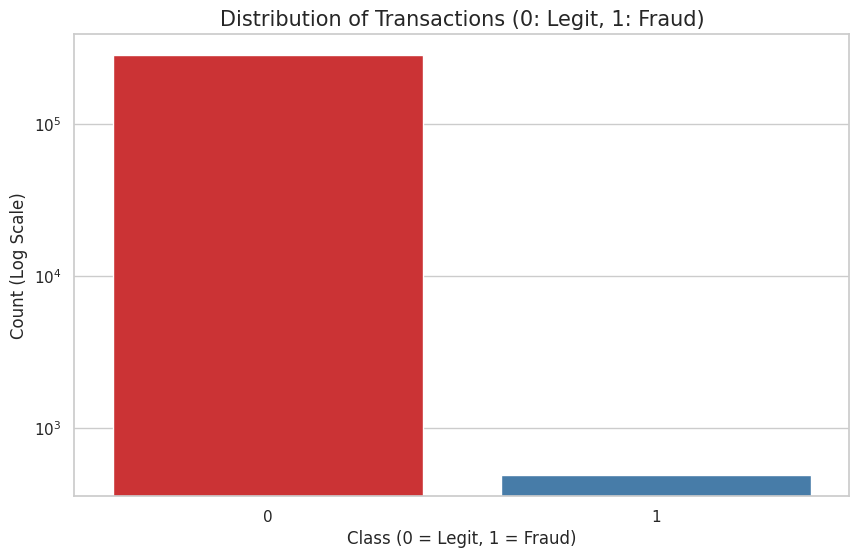

In [15]:
# Calculate frequency
class_counts = df_raw['Class'].value_counts()
fraud_pct = (class_counts[1] / len(df_raw)) * 100

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df_raw, hue='Class', palette='Set1', legend=False)

# Add annotations to show the scale difference
plt.title('Distribution of Transactions (0: Legit, 1: Fraud)', fontsize=15)
plt.yscale('log') # Log scale is essential because fraud is so rare
plt.ylabel('Count (Log Scale)')
plt.xlabel('Class (0 = Legit, 1 = Fraud)')

print(f"Total Transactions: {len(df_raw)}")
print(f"Legit Transactions: {class_counts[0]}")
print(f"Fraud Transactions: {class_counts[1]}")
print(f"Percentage of Fraud: {fraud_pct:.4f}%")

* Outcome: Confirmed an extreme Class Imbalance ($0.17\%$ fraud).
* Insight: Standard accuracy will be a useless metric; we must focus on Precision-Recall in later phases.

## Feature Distribution (Time & Amount)
Unlike the $V1-V28$ features (which are already scaled), Time and Amount are in their raw units. We need to see if they contain obvious fraud patterns.

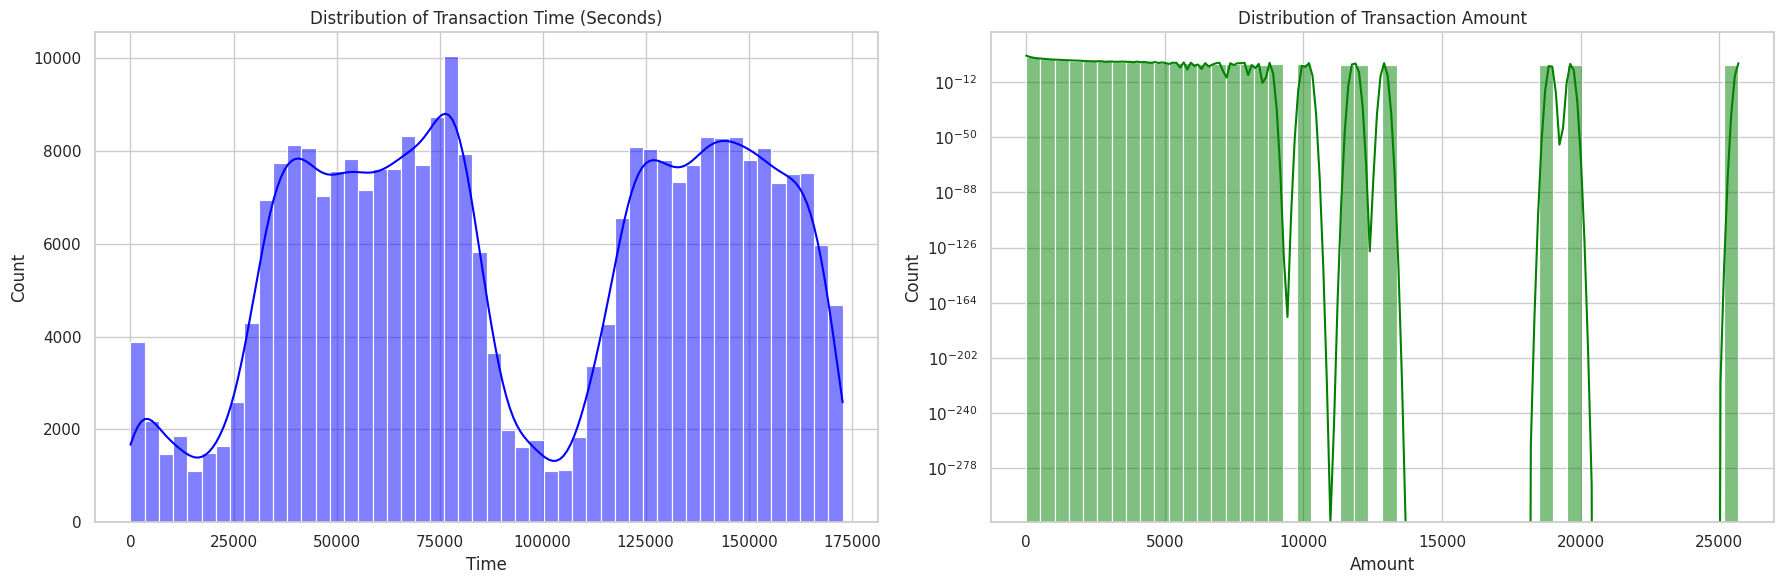

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot Time distribution
sns.histplot(df_raw['Time'], bins=50, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Distribution of Transaction Time (Seconds)')

# Plot Amount distribution
sns.histplot(df_raw['Amount'], bins=50, kde=True, ax=ax[1], color='green')
ax[1].set_title('Distribution of Transaction Amount')
ax[1].set_yscale('log') # Amounts can vary wildly

plt.tight_layout()
plt.show()

* **Time Distribution:**
  * Outcome: Shows two distinct "waves" of activity, likely representing day and night cycles.
  * Insight: Fraud doesn't strictly follow these cycles; checking if fraud spikes during "low-activity" hours will be key.

* **Amount Distribution:**
  * Outcome: Fraudulent transactions are often relatively small (the mean is often around $\$122$).
  * Insight: High-value transactions aren't always the biggest red flags; fraudsters often use smaller amounts to "test" a card or stay under automated detection thresholds.

## Investigating Fraudulent Behavior
Does fraud happen for specific amounts? We’ll compare the stats of Legit vs. Fraud transactions.

--- Transaction Amount Summary by Class ---
        Fraudulent     Legitimate
count   492.000000  284315.000000
mean    122.211321      88.291022
std     256.683288     250.105092
min       0.000000       0.000000
25%       1.000000       5.650000
50%       9.250000      22.000000
75%     105.890000      77.050000
max    2125.870000   25691.160000


/tmp/ipython-input-3098830126.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amount', data=df_raw, showfliers=False, palette='Set2')


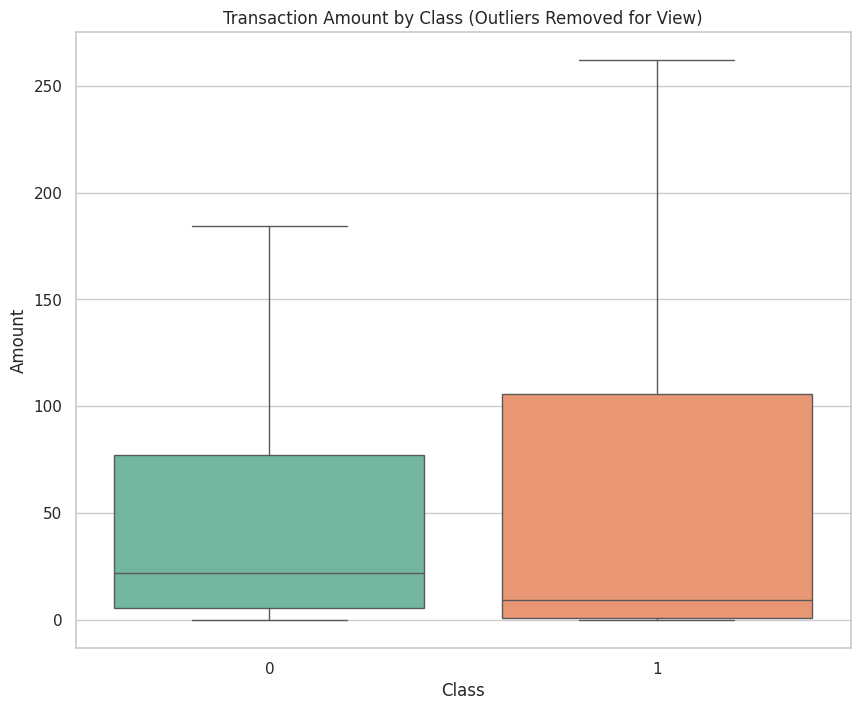

In [17]:
print("--- Transaction Amount Summary by Class ---")
fraud_stats = df_raw[df_raw['Class'] == 1]['Amount'].describe()
legit_stats = df_raw[df_raw['Class'] == 0]['Amount'].describe()

summary_df = pd.DataFrame({
    'Fraudulent': fraud_stats,
    'Legitimate': legit_stats
})

print(summary_df)

# Visualizing the difference with a boxplot (ignoring extreme outliers for clarity)
plt.figure(figsize=(10, 8))
sns.boxplot(x='Class', y='Amount', data=df_raw, showfliers=False, palette='Set2')
plt.title('Transaction Amount by Class (Outliers Removed for View)')
plt.show()

In [19]:
# Save the path for the notebook
%store df_raw
print("Variable 'df_raw' stored for next notebook.")

Stored 'df_raw' (DataFrame)
Variable 'df_raw' stored for next notebook.


## Correlation Analysis
This visualization identifies which $V$ features have the strongest relationship with the Class label.

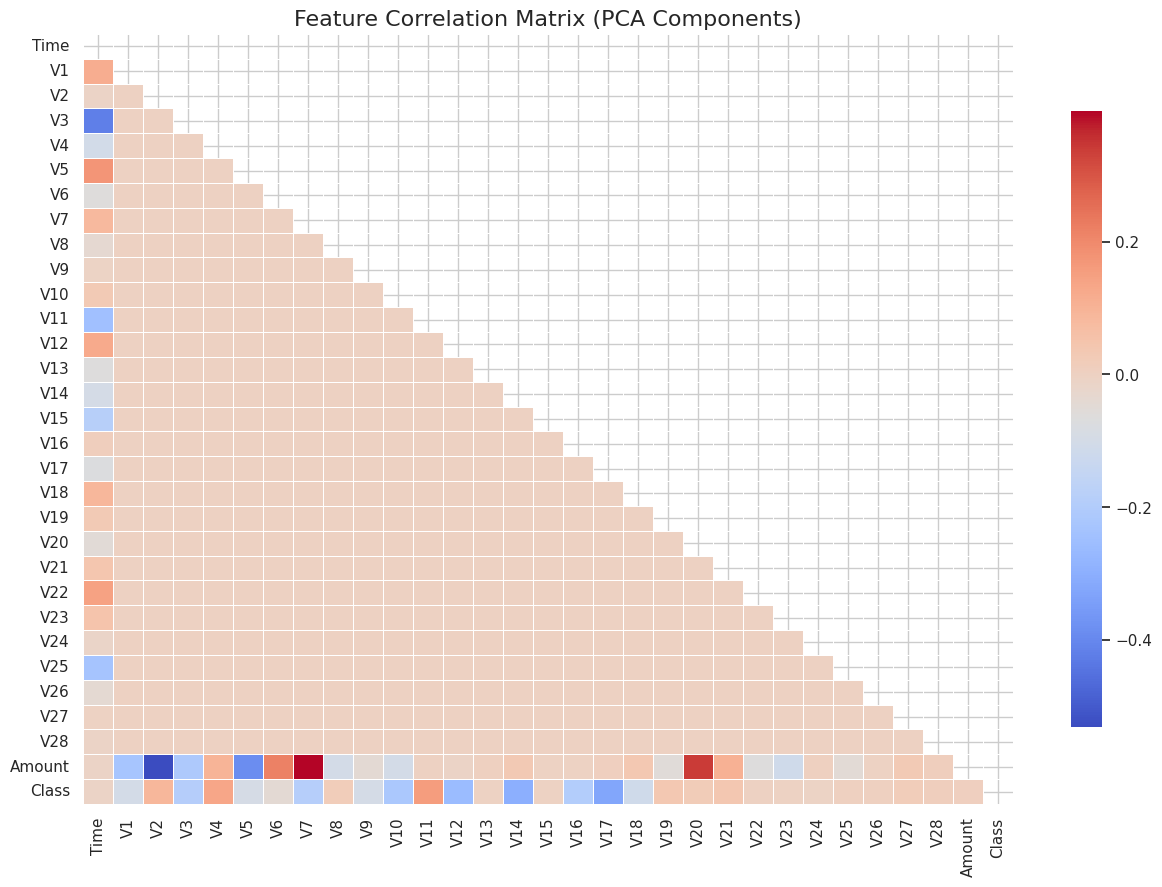

In [20]:
# Calculate the correlation matrix
corr = df_raw.corr()

# Create a mask for the upper triangle (optional, for cleaner look)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Feature Correlation Matrix (PCA Components)', fontsize=16)
plt.show()

In [21]:
# --- Targeted Correlation ---
# Let's see which features correlate MOST with Class
class_corr = corr['Class'].sort_values(ascending=False)

print("--- Top 5 Features Positively Correlated with Fraud ---")
print(class_corr.head(6)[1:]) # Excluding Class itself

print("\n--- Top 5 Features Negatively Correlated with Fraud ---")
print(class_corr.tail(5))

--- Top 5 Features Positively Correlated with Fraud ---
V11    0.154876
V4     0.133447
V2     0.091289
V21    0.040413
V19    0.034783
Name: Class, dtype: float64

--- Top 5 Features Negatively Correlated with Fraud ---
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64
